# Bayesian Cox Model Demo 

## 1. Imports

In [7]:

import pymc as pm
import pytensor.tensor as pt
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd


## 2. Toy dataset

In [8]:

# Three-subject toy dataset
t = np.array([5, 8, 10])
delta = np.array([1, 0, 1])
x = np.array([0, 1, 1])
breaks = np.array([0, 7, 999])


## 3. Build and sample the model

In [9]:

with pm.Model() as model:
    beta = pm.Normal("beta", 0, 2)
    lambda_raw = pm.Gamma("lambda_raw", alpha=2, beta=1, shape=2)
    def hazard(i):
        return pt.exp(beta * x[i]) * lambda_raw
    logL = 0
    for i in range(3):
        g = 0 if t[i] < 7 else 1
        time1 = t[i] if g==0 else 7
        time2 = max(0, t[i] - 7)
        cumhaz = pt.exp(beta * x[i]) * (lambda_raw[0]*time1 + lambda_raw[1]*time2)
        logL += delta[i]*(pt.log(lambda_raw[g]) + beta*x[i]) - cumhaz
    pm.Potential("likelihood", logL)
    idata = pm.sample(500, tune=500, target_accept=0.9)


c:\Users\ZBook\anaconda3\envs\PyBH\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, lambda_raw]


c:\Users\ZBook\anaconda3\envs\PyBH\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 67 seconds.


## 4. Plot posterior distributions

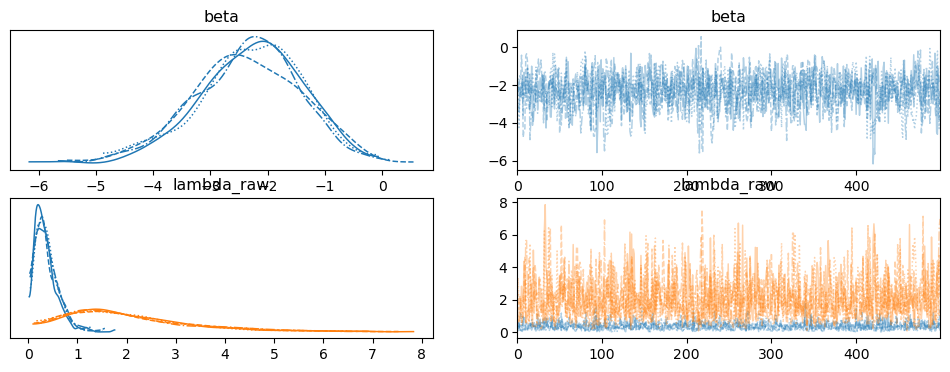

In [10]:

az.plot_trace(idata, var_names=["beta","lambda_raw"])
plt.show()


## 5. Posterior survival functions

In [11]:
times = np.linspace(0, 12, 200)
posterior = idata.posterior

# stack chain and draw into a new axis called "sample"
beta_s = posterior["beta"].stack(sample=("chain", "draw")).values
lam_s  = posterior["lambda_raw"].stack(sample=("chain", "draw")).values

def survival(t, x_i, b, lam):
    hazard = np.exp(np.dot(x_i, b)) * lam
    return np.exp(-hazard * t)
